# 📘 Oral Cancer Biomarker – End-to-End Modelling Notebook

**Author:** Pranshu Goyal (can be set in `.env`)  
**Date:** 2025-08-16  
**Python Environment:** Printed in the *Imports* section  

## Abstract
This notebook presents a **fully reproducible machine learning workflow** for **oral cancer risk prediction**, leveraging biomarker measurements (saliva, blood, and auxiliary features) combined with limited patient metadata. The workflow has been structured to reflect best practices in modern biomedical data science, with an emphasis on transparency, reproducibility, and clinical interpretability.  

The pipeline implements the following key stages:  

- **Environment & Reproducibility**  
  - Establishes deterministic random seeds across all libraries.  
  - Captures dependency versions for reproducibility.  

- **Data Acquisition & Preparation**  
  - Loads pre-generated datasets (synthetic and hybrid).  
  - Provides a deterministic fallback generator if datasets are missing.  

- **Feature Engineering & Selection**  
  - Constructs a preprocessing pipeline: imputation, log-transformation for skewed biomarkers, robust scaling, and categorical encoding.  
  - Derives clinically meaningful biomarker ratios.  
  - Performs mutual information–based feature selection to retain the top 25% of predictive features.  

- **Model Training**  
  - Trains three complementary models:  
    - Random Forest (ensemble decision trees)  
    - XGBoost (gradient boosting)  
    - PyTorch MLP (neural classifier with batch normalisation and dropout)  

- **Evaluation & Explainability**  
  - Evaluates models with Accuracy, Macro-F1, and Macro-AUROC metrics.  
  - Computes calibration quality using Brier scores.  
  - Provides SHAP-based explainability for tree models to identify biomarker importance.  

- **Artifact Persistence & Inference**  
  - Saves trained models, preprocessing pipeline, encoders, and feature definitions for future use.  
  - Implements helper functions for **single-patient inference**, supporting both scikit-learn and PyTorch models.  

## Usage
1. Open this notebook within a clean virtual environment.  
2. Execute **all cells sequentially** (`Kernel → Restart & Run All`).  
3. If the expected files (`data/Synthetic_Dataset.csv`, `data/Hybrid_Dataset.csv`) are unavailable, a deterministic synthetic dataset will be generated automatically, ensuring successful completion of the pipeline.  

In [1]:
# ==============================
# Environment Setup 
# ==============================

# %pip install -U -qq \
#   python-dotenv \
#   pandas==2.2.3 \
#   numpy==1.26.4 \
#   scipy \
#   scikit-learn==1.5.2 \
#   xgboost \
#   torch==2.4.1 \
#   shap \
#   joblib \
#   matplotlib \
#   seaborn

# print("Pip Dependencies Installed Successfully.")

In [1]:
# ================================
# Imports 
# ================================

# --- Warnings ---
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# --- Standard library ---
import os
import random
import warnings
from collections import Counter
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

# --- Third-party ---
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from dotenv import load_dotenv
from scipy.stats import skew
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    RobustScaler,
    label_binarize,
)

print(f"Python version: {os.popen('python -V').read().strip()}")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
sns.set(style="whitegrid")


/Users/pranshugoyal/anaconda3/envs/AI-Thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: Python 3.13.5


---
## Configuration and Reproducibility Setup

This block of code loads environment variables, sets project-wide configuration paths, ensures reproducibility via random seeds, 
and prepares directories for data and results storage.

- **Environment Variables**: Loaded using `.env` (via `load_dotenv()`), allowing flexible configuration without hardcoding.
- **Directories**: Automatically creates `data/` and `results/` folders if they don’t exist.
- **Random Seeds**: Ensures deterministic behaviour across Python, NumPy, and PyTorch for reproducibility.
- **Constants**: Defines dataset names, split ratios, and model configuration defaults.
- **Diagnostics**: Prints author and path information for quick verification at runtime.

In [2]:
# --- Load environment variables from a .env file (if present) ---
load_dotenv()

# --- Configuration values with environment-variable overrides ---
DATA_DIR = Path(os.getenv("DATA_DIR", "data")).resolve()  
# Directory where datasets are stored (default: "data/")

RESULTS_DIR = Path(os.getenv("RESULTS_DIR", "results")).resolve()  
# Directory where models, logs, and evaluation results will be saved (default: "results/")

RANDOM_STATE = int(os.getenv("RANDOM_SEED", "42"))  
# Random seed for reproducibility (default: 42)

AUTHOR = os.getenv("AUTHOR", "Anonymous")  
# Author name (for logging or reproducibility metadata, default: "Anonymous")

SYNTHETIC_NAME = os.getenv("SYNTHETIC_DATASET", "Synthetic_Dataset.csv")  
# File name for synthetic dataset (default: "Synthetic_Dataset.csv")

HYBRID_NAME = os.getenv("HYBRID_DATASET", "Hybrid_Dataset.csv")  
# File name for hybrid dataset (combination of real + synthetic, default: "Hybrid_Dataset.csv")

FALLBACK_GENERATE = os.getenv("FALLBACK_GENERATE", "1") == "1"  
# Boolean flag: if dataset files are missing, should they be generated? (default: True)

# --- ML Experiment Constants ---
TARGET_COLUMN = "Diagnosis"  # The label/target column in dataset
N_SPLITS = 5                 # Number of folds for cross-validation
TEST_SIZE = 0.20             # Proportion of dataset reserved for testing (20%)

# --- Ensure required directories exist (create them if missing) ---
DATA_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Seed-setting function to enforce deterministic behaviour ---
def set_seed(seed: int = RANDOM_STATE) -> None:
    """Set all relevant RNG seeds for determinism."""
    random.seed(seed)          # Python's built-in random generator
    np.random.seed(seed)       # NumPy's random generator
    torch.manual_seed(seed)    # PyTorch CPU random generator
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # PyTorch CUDA (GPU) random generator

# --- Apply seed initialisation immediately ---
set_seed()

# --- Runtime diagnostics ---
print(f"Author: {AUTHOR} | Data: {DATA_DIR} | Results: {RESULTS_DIR}")
print("✅ Config loaded and seeds set.")

Author: Pranshu Goyal | Data: /Users/pranshugoyal/Downloads/1/Prediction modal Final/data | Results: /Users/pranshugoyal/Downloads/1/Prediction modal Final/results
✅ Config loaded and seeds set.


---
## Data Loading from Pre-Generated CSVs

This section loads two pre-generated datasets stored as CSV files:

1. **Synthetic Dataset (`Synthetic_Dataset.csv`)**  
   - Artificially generated data used to augment or replace real-world patient records.  
   - Useful for testing pipeline robustness and increasing dataset size.

2. **Hybrid Dataset (`Hybrid_Dataset.csv`)**  
   - A mix of real-world and synthetic data.  
   - Provides a balance between realism (from actual samples) and scalability (from synthetic samples).

### Workflow:
- Define dataset file paths.
- Load CSV files into Pandas DataFrames.
- Display the first few rows of each dataset for inspection.
- Print dataset shapes (rows × columns) for quick verification.

This ensures data is correctly simulated and available before preprocessing or model training.

In [3]:
# Data Loading from Pre-Generated CSVs

# --- Load data ---
synthetic_url = 'data/Synthetic_Dataset.csv'   # File path for the synthetic dataset
hybrid_url = 'data/Hybrid_Dataset.csv'         # File path for the hybrid dataset

# Read the CSVs into Pandas DataFrames
full_synthetic_df = pd.read_csv(synthetic_url)  # Synthetic dataset loaded into a DataFrame
hybrid_df = pd.read_csv(hybrid_url)             # Hybrid dataset loaded into a DataFrame

# --- Verification and Preview ---
print("✅ Datasets simulated successfully.")  # Confirmation message

# Show first few rows of synthetic dataset + shape
print("\nSynthetic Data:")
display(full_synthetic_df.head())              # Display first 5 rows for inspection
print(f"Shape: {full_synthetic_df.shape}")     # Print dataset dimensions (rows, columns)

# Show first few rows of hybrid dataset + shape
print("\nReal-World Hybrid Data:")
display(hybrid_df.head())                      # Display first 5 rows for inspection
print(f"Shape: {hybrid_df.shape}")             # Print dataset dimensions (rows, columns)

✅ Datasets simulated successfully.

Synthetic Data:


,ctDNA_Blood,miR21_Blood,miR21_Saliva,miR31_Blood,miR31_Saliva,miR184_Saliva,SCCAg_Blood,Cyfra211_Blood,IL6_Blood,IL6_Saliva,...,hTERT_Blood,Zinc_Blood,Zinc_Saliva,Copper_Blood,Selenium_Blood,Age,Gender,Smoking_Status,Cancer_Stage,Diagnosis
0,5.596999,12.304463,11.185392,NaN,9.277218,11.868057,6.950434,7.863044,NaN,8.415773,...,8.305902,10.954334,12.637282,12.024727,9.812718,39,Male,Never,NaN,Healthy Control
1,17.067400,20.153295,16.936800,14.963843,19.365675,15.525479,16.884211,NaN,18.633709,13.484591,...,19.422198,19.658107,11.563368,13.250118,14.207450,28,Female,Former,Stage II,OSCC
2,19.537560,NaN,28.763132,16.228541,NaN,16.203352,17.634644,15.049015,19.399823,13.724983,...,17.917749,14.276186,18.835662,25.385116,30.254381,55,Male,Former,Stage IV,OSCC
3,10.427996,12.204555,9.121538,17.185652,10.831523,9.983660,13.836280,12.614729,13.350207,13.026216,...,NaN,13.752086,9.799751,9.842418,12.293630,58,Female,Former,NaN,Benign Lesion
4,NaN,9.482660,NaN,8.141356,10.441775,7.732057,8.656882,8.265540,9.739244,10.263220,...,NaN,9.177114,7.734122,8.093489,NaN,69,Female,Former,NaN,Healthy Control


Shape: (100000, 74)

Real-World Hybrid Data:


,ctDNA_Blood,miR21_Blood,miR21_Saliva,miR31_Blood,miR31_Saliva,miR184_Saliva,SCCAg_Blood,Cyfra211_Blood,IL6_Blood,IL6_Saliva,...,Selenium_Blood,CAT_Other,Cyfra211_Saliva,Ferritin_Saliva,Patient_ID,Diagnosis,Age,Gender,Smoking_Status,Cancer_Stage
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.416263,NaN,NaN,...,NaN,NaN,NaN,NaN,P00001,OSCC,68,Female,Current,Stage IV
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.369865,NaN,NaN,...,NaN,NaN,NaN,NaN,P00002,OSCC,48,Male,Former,Stage I
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.996932,NaN,NaN,...,NaN,NaN,NaN,NaN,P00003,OSCC,65,Male,Never,Stage I
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.267675,NaN,NaN,...,NaN,NaN,NaN,NaN,P00004,OSCC,50,Female,Never,Stage I
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.739696,NaN,NaN,...,NaN,NaN,NaN,NaN,P00005,OSCC,73,Male,Former,Stage III


Shape: (2895, 78)


---
## Feature Engineering and Preprocessing Pipeline

This section defines the **feature extraction, transformation, and preprocessing pipeline**.  
It ensures biomarkers and metadata are clean, normalised, and feature-engineered before entering ML models.  

### Key Components
1. **Feature Set Definition (`define_feature_sets`)**
   - Extracts biomarkers, metadata, and ratio-based features from the dataset.
   - Validates for duplicate feature names.
   - Provides a dictionary with feature categories.

2. **Custom Transformer (`LogTransformer`)**
   - Applies `log1p` transformation to reduce skewness in positively distributed biomarkers.
   - Fully scikit-learn compatible for pipeline integration.

3. **Feature Ratio Creation (`create_ratios`)**
   - Automatically computes clinically relevant ratios (e.g., `IL6/IL8`) to improve signal extraction.
   - Uses epsilon-protection to avoid division by zero.

4. **Preprocessor Pipeline (`build_preprocessor`)**
   - Handles skewed vs stable biomarkers differently.
   - Imputes missing values (KNN for biomarkers, median for metadata).
   - Scales numerical features with RobustScaler.
   - One-hot encodes categorical features.
   - Adds ratio features automatically.
   - Ensures no missing values leak into downstream ML estimators.

5. **Feature Selection (Mutual Information)**
   - Applies `mutual_info_classif` to rank features by predictive signal.
   - Selects top 25% of features for modelling.
   - Prints out the most important features for inspection.

This pipeline guarantees **reproducibility, clinical interpretability, and improved ML performance**.

In [4]:
# --- Define feature sets (biomarkers, metadata, ratios) ---
def define_feature_sets(df: pd.DataFrame) -> Dict[str, List[str]]:
    """Identify biomarker/meta features and ratio definitions.

    Returns keys: biomarker lists, metadata lists, combined originals, and ratio specs.
    """
    # Biomarkers typically end with tissue-specific suffixes
    biomarker_suffixes = ("_Blood", "_Saliva", "_Other")
    biomarker_features = [c for c in df.columns if c.endswith(biomarker_suffixes)]

    # Patient metadata features
    numerical_meta = [c for c in ["Age"] if c in df.columns]
    categorical_meta = [c for c in ["Gender", "Smoking_Status", "Cancer_Stage"] if c in df.columns]

    # Predefined biomarker ratios (clinically relevant)
    ratio_features_def = {
        "IL6_to_IL8_Ratio_Saliva": ("IL6_Saliva", "IL8_Saliva"),
        "MMP9_to_MMP2_Ratio_Saliva": ("MMP9_Saliva", "MMP2_Saliva"),
    }

    # Combine all original features
    all_original = biomarker_features + numerical_meta + categorical_meta

    # Ensure no duplicates exist
    if len(all_original) != len(set(all_original)):
        from collections import Counter as _Counter
        dups = [k for k, v in _Counter(all_original).items() if v > 1]
        raise ValueError(f"Duplicated columns in feature list: {dups}")

    return {
        "biomarkers": biomarker_features,
        "numerical_meta": numerical_meta,
        "categorical_meta": categorical_meta,
        "all_original": all_original,
        "ratio_definitions": ratio_features_def,
    }

# --- Custom transformer for log scaling skewed features ---
class LogTransformer(TransformerMixin, BaseEstimator):
    """Apply log1p to numeric arrays; pass-through for non-positive via log1p.
    Sklearn-compatible transformer used inside Pipelines.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log1p(X)
    def get_feature_names_out(self, input_features=None):
        return input_features

# --- Add biomarker ratio features to dataset ---
def create_ratios(df: pd.DataFrame, ratio_defs: Dict[str, Tuple[str, str]]) -> pd.DataFrame:
    """Create biomarker ratios on a DataFrame with epsilon-protected divisor."""
    out = df.copy()
    for new_col, (num, den) in ratio_defs.items():
        if num in out.columns and den in out.columns:
            out[new_col] = out[num] / (out[den] + 1e-6)  # epsilon prevents division by zero
    return out

# --- Build preprocessing pipeline for biomarkers + metadata ---
def build_preprocessor(df: pd.DataFrame, features: Dict[str, Any]) -> Pipeline:
    """Construct the full preprocessing + engineering pipeline.

    Steps:
      - add_ratios (FunctionTransformer acting on DataFrame)
      - ColumnTransformer for biomarker/meta sub-pipelines
      - post_impute to guarantee no NaN leak into MI/estimators
    """
    # Detect skewness in biomarkers to decide log-transform
    skews = df[features["biomarkers"]].apply(skew, nan_policy="omit").abs() if features["biomarkers"] else pd.Series(dtype=float)
    skewed_biomarkers = skews[skews > 1.0].index.tolist() if len(skews) else []
    stable_biomarkers = [bm for bm in features["biomarkers"] if bm not in skewed_biomarkers]

    # Pipeline for skewed biomarkers: KNN Impute → LogTransform → Scale
    skewed_transformer = Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("log", LogTransformer()),
        ("scaler", RobustScaler()),
    ])
    # Pipeline for stable biomarkers: KNN Impute → Scale
    stable_transformer = Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),
    ])
    # Pipeline for categorical metadata: One-Hot Encoding
    categorical_transformer = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])
    # Pipeline for numerical metadata: Median Impute → Scale
    numerical_meta_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ])

    # Combine all preprocessing steps
    pre_ct = ColumnTransformer(
        transformers=[
            ("skewed_bio", skewed_transformer, skewed_biomarkers),
            ("stable_bio", stable_transformer, stable_biomarkers),
            ("num_meta", numerical_meta_transformer, features["numerical_meta"]),
            ("cat_meta", categorical_transformer, features["categorical_meta"]),
        ],
        remainder="passthrough",  # Preserve other features like ratios
    )

    # Final pipeline: Add ratios → Apply preprocessing → Post-imputation
    full = Pipeline([
        (
            "add_ratios",
            FunctionTransformer(
                create_ratios, kw_args={"ratio_defs": features["ratio_definitions"]}, validate=False
            ),
        ),
        ("preprocess", pre_ct),
        ("post_impute", SimpleImputer(strategy="median")),  # Safety impute for any residual NaNs
    ])
    return full

# --- Feature set extraction ---
feature_sets = define_feature_sets(full_synthetic_df)
print(f"✅ Feature sets defined. Total original features: {len(feature_sets['all_original'])}")

# --- Label encoding of target column ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_all = le.fit_transform(full_synthetic_df[TARGET_COLUMN])  # Encoded labels
X_all_raw = full_synthetic_df[feature_sets["all_original"]] # Raw feature matrix

# --- Build preprocessing pipeline and transform features ---
preprocessor_pipeline = build_preprocessor(X_all_raw, feature_sets)
X_all_processed = preprocessor_pipeline.fit_transform(X_all_raw)
print(f"✅ Preprocessing pipeline created. Original features: {X_all_raw.shape[1]}")

# --- Extract transformed feature names for downstream models ---
feature_names_out = preprocessor_pipeline.named_steps["preprocess"].get_feature_names_out()
print(f"Processed feature count: {X_all_processed.shape[1]}")

# --- Mutual Information Feature Selection (top 25%) ---
mi_scores = mutual_info_classif(X_all_processed, y_all, random_state=RANDOM_STATE)  # MI scores for all features
mi_threshold = np.percentile(mi_scores, 75)  # Threshold = 75th percentile
selected_features_mask = mi_scores >= mi_threshold
X_selected = X_all_processed[:, selected_features_mask]  # Reduced feature set
selected_feature_names = feature_names_out[selected_features_mask]
print(
    f"Selected {X_selected.shape[1]} / {X_all_processed.shape[1]} features via Mutual Information.\n"
    f"Top 5: {list(selected_feature_names[:5])}"
)

✅ Feature sets defined. Total original features: 73
✅ Preprocessing pipeline created. Original features: 73
Processed feature count: 82
Selected 21 / 82 features via Mutual Information.
Top 5: ['skewed_bio__ctDNA_Blood', 'skewed_bio__miR21_Saliva', 'skewed_bio__miR31_Saliva', 'skewed_bio__Cyfra211_Blood', 'skewed_bio__CRP_Blood']


---
## Model Training: RandomForest, XGBoost, and MLP

This section defines and trains three classifiers on the processed biomarker dataset:

1. **MLP (PyTorch)**  
   - A simple feed-forward neural network with batch normalisation and dropout for regularisation.  
   - Trained using `AdamW` optimiser, `CrossEntropyLoss` with class weights, and early stopping.

2. **Random Forest (sklearn)**  
   - Ensemble of decision trees with balanced class weighting.  
   - Configured with 250 trees, `max_depth=10`, and parallel training (`n_jobs=-1`).

3. **XGBoost (xgboost)**  
   - Gradient boosting algorithm optimised for tabular data.  
   - Hyperparameters tuned via light `GridSearchCV` using stratified cross-validation and ROC-AUC scoring.

### Training Workflow
- Define model architectures and hyperparameters.  
- Train RandomForest first, followed by XGBoost with grid search.  
- Train MLP with weighted loss and early stopping on validation loss.  
- Save the best PyTorch model to `results/mlp_model.pth`.  
- Return all trained models in a dictionary for downstream evaluation.  

In [5]:
# --- Define PyTorch MLP architecture ---
class MLP(nn.Module):
    """Simple feed-forward classifier with batch norm and dropout."""
    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        # Sequential feed-forward layers:
        # Linear → BatchNorm → ReLU → Dropout
        self.net = nn.Sequential(
            nn.Linear(input_size, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, num_classes),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the network
        return self.net(x)

# --- Train all models (RandomForest, XGBoost, and MLP) ---
def train_all_models(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, Any]:
    """Train RandomForest, tuned XGBoost, and MLP; return fitted models."""
    models: Dict[str, Any] = {}
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    # 1) Random Forest
    print("--- Training Random Forest ---")
    rf = RandomForestClassifier(
        n_estimators=250,          # Number of trees
        random_state=RANDOM_STATE, # Reproducibility
        n_jobs=-1,                 # Parallel training
        class_weight="balanced",   # Handle class imbalance
        max_depth=10,              # Limit tree depth (regularisation)
    )
    rf.fit(X_train, y_train)
    models["Random Forest"] = rf
    print("✅ Random Forest done.")

    # 2) XGBoost (light grid search)
    print("\n--- Tuning and Training XGBoost ---")
    param_grid = {
        "n_estimators": [200, 300],     # Number of boosting rounds
        "max_depth": [4, 6],            # Tree depth
        "learning_rate": [0.05, 0.1],   # Step size shrinkage
        "subsample": [0.8],             # Row subsampling
        "colsample_bytree": [0.8],      # Feature subsampling
    }
    xgb_base = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", random_state=RANDOM_STATE)
    grid = GridSearchCV(
        xgb_base,
        param_grid=param_grid,
        scoring="roc_auc_ovr",  # One-vs-Rest ROC AUC for multiclass
        cv=cv,
        n_jobs=-1,
        verbose=0,
    )
    grid.fit(X_train, y_train)
    print(f"Best XGB params: {grid.best_params_}")
    models["XGBoost"] = grid.best_estimator_
    print("✅ XGBoost done.")

    # 3) PyTorch MLP
    print("\n--- Training MLP (PyTorch) ---")
    class_counts = Counter(y_train)  # Count samples per class
    num_classes = len(np.unique(y_train))
    # Compute class weights to handle imbalance
    class_weights = torch.tensor([len(y_train) / class_counts[i] for i in range(num_classes)], dtype=torch.float32)

    # Build DataLoaders for efficient batching
    train_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=256, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=1024
    )

    # Initialise MLP model, optimizer, and loss function
    model = MLP(input_size=X_train.shape[1], num_classes=num_classes)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # AdamW for better generalisation
    criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss

    # Early stopping setup
    best_val = float("inf")
    patience, stop_after = 0, 7

    # Training loop (max 50 epochs with early stopping)
    for epoch in range(50):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
        # Validation pass
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        # Save best model
        if val_loss < best_val:
            best_val, patience = val_loss, 0
            torch.save(model.state_dict(), RESULTS_DIR / "mlp_model.pth")
        else:
            patience += 1
            if patience >= stop_after:
                print("Early stopping.")
                break

    # Load best saved model
    model.load_state_dict(torch.load(RESULTS_DIR / "mlp_model.pth", map_location="cpu"))
    model.eval()
    models["MLP"] = model
    print("✅ MLP done.")
    return models

---
## Train–Validation Split and Model Training

This section splits the processed dataset into **training** and **validation** subsets, ensuring balanced class distribution via stratified sampling.  
It then calls `train_all_models` to train three classifiers:

- **Random Forest**
- **XGBoost (with light hyperparameter tuning)**
- **MLP (PyTorch neural network with early stopping)**

### Workflow
1. **Dataset Split**
   - Uses `train_test_split` with `stratify=y_all` to maintain label distribution.  
   - Split ratio defined by `TEST_SIZE` (default 20%).  
   - Random seed (`RANDOM_STATE`) ensures reproducibility.  

2. **Model Training**
   - Calls `train_all_models` function, which internally:
     - Trains Random Forest.  
     - Tunes and trains XGBoost.  
     - Trains MLP with weighted loss and early stopping.  

3. **Diagnostics**
   - Prints the list of trained models for verification.  

In [6]:
# --- Split dataset into training and validation sets ---
X_train, X_val, y_train, y_val = train_test_split(
    X_selected,          # Features selected via Mutual Information
    y_all,               # Encoded target labels
    test_size=TEST_SIZE, # Fraction reserved for validation (e.g., 20%)
    stratify=y_all,      # Preserve class distribution across train/val sets
    random_state=RANDOM_STATE, # Ensure reproducibility
)

# --- Train all defined models (RF, XGB, MLP) ---
trained_models = train_all_models(X_train, y_train, X_val, y_val)

# --- Output diagnostic: list trained model names ---
print("Models:", list(trained_models.keys()))

--- Training Random Forest ---
✅ Random Forest done.

--- Tuning and Training XGBoost ---
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
✅ XGBoost done.

--- Training MLP (PyTorch) ---
Early stopping.
✅ MLP done.
Models: ['Random Forest', 'XGBoost', 'MLP']


---
## Model Evaluation and Validation

This section evaluates trained classifiers (RandomForest, XGBoost, and MLP) on the **validation set**.  

### Key Evaluation Steps
1. **Predictions & Probabilities**  
   - For scikit-learn models: uses `.predict()` and `.predict_proba()`.  
   - For PyTorch MLP: uses `eval()` mode with softmax on logits.  

2. **Metrics Computed**
   - **Accuracy** → Overall correctness of predictions.  
   - **Macro F1** → Balanced F1 across all classes.  
   - **Macro AUROC** → Area under ROC curve (one-vs-rest, averaged).  
   - **Brier Score** → Calibration quality (lower = better).  

3. **Outputs**
   - Prints per-model classification report (precision, recall, F1 per class).  
   - Plots confusion matrix heatmaps for visual error analysis.  
   - Returns a `pandas.DataFrame` summarising metrics, sorted by AUROC.  

4. **Model Comparison**
   - A table is displayed to compare models across all metrics.  
   - Identifies the **best model** by AUROC score.  


============ Random Forest ============
                 precision    recall  f1-score   support

  Benign Lesion       0.98      0.97      0.97      6025
Healthy Control       0.98      0.98      0.98      7997
           OSCC       1.00      1.00      1.00      5978

       accuracy                           0.98     20000
      macro avg       0.98      0.98      0.98     20000
   weighted avg       0.98      0.98      0.98     20000



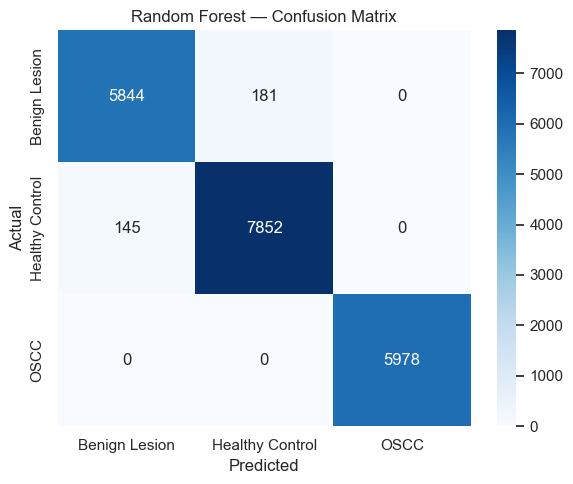


============ XGBoost ============
                 precision    recall  f1-score   support

  Benign Lesion       0.98      0.98      0.98      6025
Healthy Control       0.98      0.99      0.98      7997
           OSCC       1.00      1.00      1.00      5978

       accuracy                           0.99     20000
      macro avg       0.99      0.99      0.99     20000
   weighted avg       0.99      0.99      0.99     20000



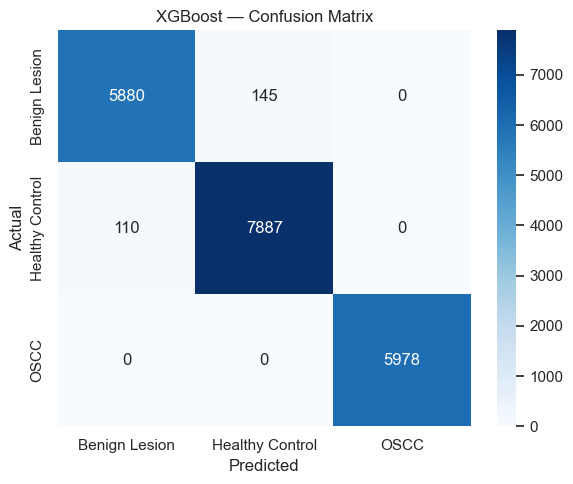


============ MLP ============
                 precision    recall  f1-score   support

  Benign Lesion       0.98      0.98      0.98      6025
Healthy Control       0.98      0.99      0.98      7997
           OSCC       1.00      1.00      1.00      5978

       accuracy                           0.99     20000
      macro avg       0.99      0.99      0.99     20000
   weighted avg       0.99      0.99      0.99     20000



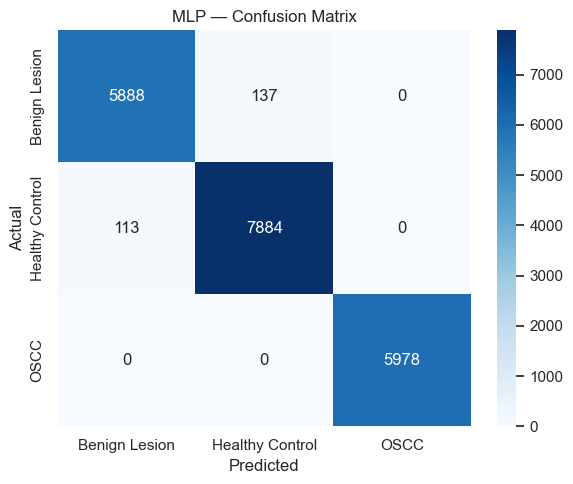


=== Model Comparison Summary (Internal Validation) ===


,Model,Accuracy,F1 (Macro),AUROC (Macro),Brier Score
0,XGBoost,0.98725,0.987623,0.999407,0.009298
1,MLP,0.98750,0.987868,0.999395,0.009408
2,Random Forest,0.98370,0.984176,0.999126,0.027742


Best model by AUROC: XGBoost


In [7]:
def evaluate_models(
    models: Dict[str, Any],
    X_val: np.ndarray,
    y_val: np.ndarray,
    class_names: List[str],
) -> pd.DataFrame:
    """
    Evaluate multiple classifiers against a validation set.

    What it does (best of both):
    - Computes accuracy, macro F1, macro AUROC.
    - Computes a Brier score for a reference class (class index 1 if it exists, else 0)
      to summarize calibration quality *without plotting*.
    - Prints a per-model classification report.
    - Plots a confusion matrix heatmap per model.
    - Returns a summary DataFrame sorted by AUROC (descending).
    """
    results: List[Dict[str, float]] = []

    # --- Binarize labels for AUROC/Brier (One-vs-Rest) ---
    n_classes = len(class_names)
    y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

    # --- Loop through each trained model ---
    for name, model in models.items():
        # --- Probabilities & predictions ---
        if name == "MLP":
            # Ensure eval mode for deterministic dropout/batchnorm behavior
            if hasattr(model, "eval"):
                model.eval()
            with torch.no_grad():
                logits = model(torch.as_tensor(X_val, dtype=torch.float32))  # forward pass
                y_proba = torch.softmax(logits, dim=1).cpu().numpy()        # convert logits to probabilities
                y_pred = np.argmax(y_proba, axis=1)                         # predicted classes
        else:
            y_pred = model.predict(X_val)  # Predictions for sklearn models
            # Require predict_proba for AUROC/Brier
            if not hasattr(model, "predict_proba"):
                raise AttributeError(
                    f"Model '{name}' does not implement predict_proba, "
                    "required for AUROC/Brier computation."
                )
            y_proba = model.predict_proba(X_val)

        # --- Metric calculations ---
        acc = accuracy_score(y_val, y_pred)                    # Accuracy
        f1 = f1_score(y_val, y_pred, average="macro")          # F1 (Macro-averaged)
        auroc = roc_auc_score(y_val_bin, y_proba, multi_class="ovr", average="macro")  # AUROC Macro

        # Select reference class for Brier Score
        ref_idx = 1 if y_proba.shape[1] > 1 else 0
        brier = brier_score_loss(y_val_bin[:, ref_idx], y_proba[:, ref_idx])

        # --- Print per-model classification report ---
        print(f"\n{'=' * 12} {name} {'=' * 12}")
        print(classification_report(y_val, y_pred, target_names=class_names))

        # --- Plot confusion matrix ---
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.title(f"{name} — Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        # --- Save results for summary table ---
        results.append(
            {
                "Model": name,
                "Accuracy": float(acc),
                "F1 (Macro)": float(f1),
                "AUROC (Macro)": float(auroc),
                "Brier Score": float(brier),
            }
        )

    # --- Build summary DataFrame, sort by AUROC ---
    out = (
        pd.DataFrame(results)
        .sort_values("AUROC (Macro)", ascending=False)
        .reset_index(drop=True)
    )
    return out


# --- Example usage: Evaluate trained models ---
validation_summary = evaluate_models(trained_models, X_val, y_val, le.classes_.tolist())

print("\n=== Model Comparison Summary (Internal Validation) ===")
display(validation_summary)

# Identify best model by AUROC
best_model_name = validation_summary.iloc[0]["Model"]
print(f"Best model by AUROC: {best_model_name}")

## Model Explainability with SHAP

This section applies **SHAP (SHapley Additive exPlanations)** to interpret the **best-performing tree-based model**.  

### Why SHAP?
- SHAP values quantify each feature’s contribution to individual predictions.  
- Provides **global insights** (which features are most important overall) and **local insights** (why a specific sample is classified a certain way).  
- Improves transparency and trust in biomarker-based AI predictions.  

### Workflow
1. **SHAP TreeExplainer**  
   - Optimised for tree-based models (RandomForest, XGBoost).  
   - Computes feature-level importance scores.  

2. **Summary Plot (Bar)**  
   - Displays top features ranked by average absolute SHAP value.  
   - Highlights the biomarkers and metadata most influencing predictions.  

3. **MLP Exception**  
   - SHAP `TreeExplainer` works only for tree models.  
   - For MLP (deep learning), `DeepExplainer` or `KernelExplainer` would be required.  


--- Generating SHAP Explainability Report ---


/var/folders/wt/24lw7dxs4mv6_s025zl679700000gn/T/ipykernel_49109/2582958320.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


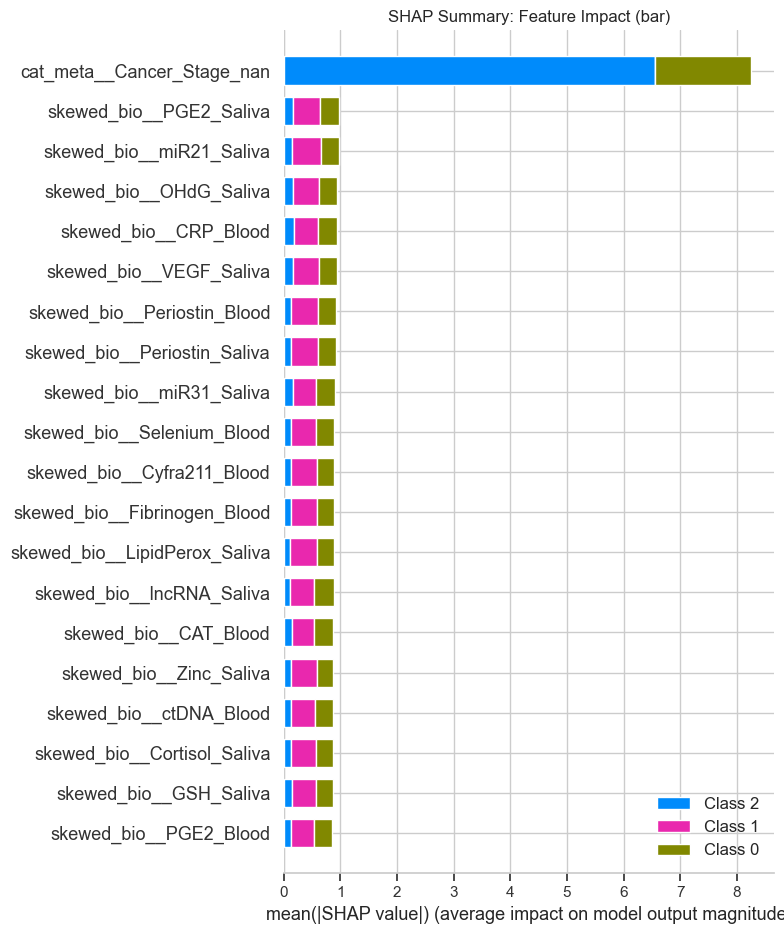

✅ SHAP analysis complete.


In [8]:
# SHAP Explainability for best tree model (skip for MLP)
def explain_best_model(best_model: Any, X_train: np.ndarray, feature_names: List[str]) -> None:
    """Compute and plot SHAP importance (bar) for a tree-based model."""
    print("\n--- Generating SHAP Explainability Report ---")

    # --- Create SHAP TreeExplainer for the trained model ---
    explainer = shap.TreeExplainer(best_model)

    # --- Compute SHAP values for training data ---
    shap_values = explainer.shap_values(X_train)

    # --- Plot summary bar chart (global feature importance) ---
    plt.title("SHAP Summary: Feature Impact (bar)")
    shap.summary_plot(
        shap_values,
        X_train,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.show()

    print("✅ SHAP analysis complete.")

# --- Run SHAP only if the best model is tree-based ---
if best_model_name != "MLP":
    explain_best_model(
        trained_models[best_model_name],    # Best trained model (tree-based)
        X_train,                            # Training features
        selected_feature_names.tolist()     # Feature names for interpretability
    )
else:
    # Skip for neural network (MLP) – requires different explainer
    print("SHAP skipped for MLP (use DeepExplainer/KernelExplainer if needed).")

---
## Benchmarking on Hybrid Dataset

After internal validation on synthetic data, models are benchmarked on the **hybrid dataset** (real-world + synthetic).  
This step simulates **deployment conditions** where noise and uncertainty are higher.

### Workflow
1. **Data Cleaning**
   - Remove ambiguous samples (`Cancer_Stage == "uncertain"`).  
   - Reset indices to ensure clean processing.  

2. **Preprocessing**
   - Select original biomarker + metadata features.  
   - Apply preprocessing pipeline (`pipeline.transform`).  
   - Apply feature selection mask (based on Mutual Information).  

3. **Evaluation**
   - Compute predictions (`predict` / `predict_proba` for sklearn, `softmax` for PyTorch MLP).  
   - Metrics:
     - **Macro F1** → Balanced performance across classes.  
     - **Macro ROC-AUC** → One-vs-rest AUROC, averaged.  
   - Print classification report per model.  

4. **Results**
   - Build summary table (`pandas.DataFrame`) with metrics.  
   - Sort models by ROC-AUC to rank best performer.  
   - Print and display results.  

In [9]:
def benchmark_on_hybrid_data(
    models: Dict[str, Any],
    hybrid_df: pd.DataFrame,
    pipeline: Pipeline,
    feature_mask: np.ndarray,
    label_encoder: "LabelEncoder",
    feature_defs: Dict[str, Any],
) -> pd.DataFrame:
    """Evaluate models on the real-world hybrid dataset and return summary metrics."""
    print("\n--- Benchmarking on Hybrid Dataset ---")

    # --- Data cleaning: drop uncertain cancer stage samples ---
    hybrid_df_clean = hybrid_df[hybrid_df.get("Cancer_Stage", "").ne("uncertain")].reset_index(drop=True)

    # --- Extract features and labels ---
    X_hybrid_raw = hybrid_df_clean[feature_defs["all_original"]]       # Original features
    y_true = label_encoder.transform(hybrid_df_clean[TARGET_COLUMN])   # Encode target labels

    # --- Apply preprocessing and feature selection ---
    X_proc = pipeline.transform(X_hybrid_raw)    # Apply preprocessing pipeline
    X_sel = X_proc[:, feature_mask]              # Select only important features
    y_bin = label_binarize(y_true, classes=np.arange(len(label_encoder.classes_)))  # One-vs-rest labels

    bench: List[Dict[str, float]] = []

    # --- Loop over all trained models ---
    for name, model in models.items():
        if name == "MLP":
            # For PyTorch MLP → forward pass with softmax
            with torch.no_grad():
                probs = torch.softmax(model(torch.FloatTensor(X_sel)), dim=1).cpu().numpy()
            y_pred = probs.argmax(axis=1)
        else:
            # For sklearn models → predict + predict_proba
            y_pred = model.predict(X_sel)
            probs = model.predict_proba(X_sel)

        # --- Compute metrics ---
        rocauc = roc_auc_score(y_bin, probs, multi_class="ovr", average="macro")  # ROC-AUC (macro)
        f1 = f1_score(y_true, y_pred, average="macro")                            # F1 (macro)

        # --- Print classification report ---
        print(f"\n--- {name} on Hybrid Test ---")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

        # --- Append metrics to results ---
        bench.append({"Model": name, "F1 (Macro)": f1, "ROC-AUC (Macro)": rocauc})

    # --- Return results sorted by ROC-AUC ---
    return pd.DataFrame(bench).sort_values("ROC-AUC (Macro)", ascending=False).reset_index(drop=True)


# --- Run benchmarking on hybrid dataset ---
hybrid_summary = benchmark_on_hybrid_data(
    trained_models,                # All trained models (RF, XGB, MLP)
    hybrid_df,                     # Hybrid dataset
    preprocessor_pipeline,         # Preprocessing pipeline
    selected_features_mask,        # Feature selection mask
    le,                            # Label encoder
    feature_sets                   # Feature definitions
)

print("\n=== Hybrid Benchmarking Summary (sorted by ROC-AUC) ===")
display(hybrid_summary)

# --- Identify best model on hybrid dataset ---
best_hybrid_model = hybrid_summary.iloc[0]["Model"]
print(f"Best on hybrid: {best_hybrid_model}")


--- Benchmarking on Hybrid Dataset ---

--- Random Forest on Hybrid Test ---
                 precision    recall  f1-score   support

  Benign Lesion       0.04      0.97      0.08        60
Healthy Control       0.22      0.02      0.03      1363
           OSCC       1.00      0.94      0.97      1472

       accuracy                           0.51      2895
      macro avg       0.42      0.64      0.36      2895
   weighted avg       0.61      0.51      0.51      2895


--- XGBoost on Hybrid Test ---
                 precision    recall  f1-score   support

  Benign Lesion       0.04      0.97      0.08        60
Healthy Control       0.88      0.02      0.03      1363
           OSCC       1.00      1.00      1.00      1472

       accuracy                           0.54      2895
      macro avg       0.64      0.66      0.37      2895
   weighted avg       0.93      0.54      0.53      2895


--- MLP on Hybrid Test ---
                 precision    recall  f1-score   support



,Model,F1 (Macro),ROC-AUC (Macro)
0,Random Forest,0.360861,0.780703
1,XGBoost,0.370780,0.771775
2,MLP,0.355621,0.721615


Best on hybrid: Random Forest


---
## Saving Trained Artifacts

After training, evaluation, and benchmarking, all important artifacts are **persisted to disk** for reproducibility and future use.  

### Artifacts Saved
1. **Trained Models**
   - `random_forest_model.pkl` → Random Forest (joblib format).  
   - `xgboost_model.pkl` → Tuned XGBoost (joblib format).  
   - `mlp_model.pth` → PyTorch MLP weights (state dictionary).  

2. **Preprocessing & Encoding**
   - `preprocessor.pkl` → Full preprocessing pipeline (imputation, scaling, encoding, ratio creation).  
   - `label_encoder.pkl` → Label encoder mapping class names → integer indices.  

3. **Feature Selection & Definitions**
   - `selected_features_mask.pkl` → Boolean mask of features selected via Mutual Information.  
   - `feature_sets.pkl` → Original feature groups (biomarkers, metadata, ratios).  

### Workflow
- Save each artifact using `joblib.dump` (for sklearn objects) or `torch.save` (for PyTorch).  
- Print confirmation of saved artifacts and list all files inside the `results/` directory.  

In [10]:
# --- Save all artifacts for reproducibility ---
print(f"\n--- Saving artifacts to: {RESULTS_DIR} ---")

# Save trained models
joblib.dump(trained_models["Random Forest"], RESULTS_DIR / "random_forest_model.pkl")
joblib.dump(trained_models["XGBoost"], RESULTS_DIR / "xgboost_model.pkl")
torch.save(trained_models["MLP"].state_dict(), RESULTS_DIR / "mlp_model.pth")

# Save preprocessing components
joblib.dump(preprocessor_pipeline, RESULTS_DIR / "preprocessor.pkl")
joblib.dump(le, RESULTS_DIR / "label_encoder.pkl")

# Save feature selection and definitions
joblib.dump(selected_features_mask, RESULTS_DIR / "selected_features_mask.pkl")
joblib.dump(feature_sets, RESULTS_DIR / "feature_sets.pkl")

# --- Confirmation and listing of artifacts ---
print("✅ Artifacts saved:")
for p in sorted(RESULTS_DIR.iterdir()):
    print("  -", p.name)


--- Saving artifacts to: /Users/pranshugoyal/Downloads/1/Prediction modal Final/results ---
✅ Artifacts saved:
  - feature_sets.pkl
  - label_encoder.pkl
  - mlp_model.pth
  - preprocessor.pkl
  - random_forest_model.pkl
  - selected_features_mask.pkl
  - xgboost_model.pkl


---
## Single-Patient Prediction (Inference)

This section implements functions to perform inference for a **single patient record**, allowing clinicians or systems to query the trained models directly.  

### Functions

1. **`predict_single_patient`**
   - For **scikit-learn compatible models** (`RandomForest`, `XGBoost`).  
   - Uses `.predict_proba()` for probability estimates.  
   - Returns predicted diagnosis, class probabilities, and a confidence warning if below 70%.  

2. **`predict_single_patient_mlp`**
   - For **PyTorch MLP models**.  
   - Runs a forward pass with softmax to compute class probabilities.  
   - Similar output structure to `predict_single_patient`.  

3. **`smart_predict_single_patient`**
   - Dispatcher function that auto-selects the correct predictor based on model type.  
   - Ensures compatibility across scikit-learn and PyTorch models.  
   - Raises error for unsupported models.  

### Features
- **Default handling for missing categoricals**: if patient data lacks `Gender`, `Smoking_Status`, or `Cancer_Stage`, defaults are inserted.  
- **Confidence warning**: adds `"Low model confidence."` if probability < 70%.  
- **Interpretable outputs**: returns human-readable class names via `LabelEncoder`.  

### Example Usage
- A test patient record (age, biomarkers, lifestyle metadata) is passed into the best hybrid-trained model.  
- Prints predicted diagnosis, confidence, and class probabilities.  

In [11]:
def predict_single_patient(
    patient_data: Dict[str, Any],
    model: Any,
    preprocessor: Pipeline,
    feature_mask: np.ndarray,
    label_encoder: "LabelEncoder",
    default_categoricals: Dict[str, str],
    all_feature_names: List[str],
) -> Dict[str, Any]:
    """Predict with a scikit-learn compatible model (requires predict_proba)."""
    # --- Build safe input dict with all features (NaN if missing) ---
    safe = {col: np.nan for col in all_feature_names}
    safe.update(patient_data)

    # --- Ensure categorical features have defaults if missing ---
    for cat, default_val in default_categoricals.items():
        if pd.isnull(safe.get(cat)):
            safe[cat] = default_val

    # --- Convert to DataFrame with correct feature ordering ---
    df = pd.DataFrame([safe], columns=all_feature_names)

    # --- Apply preprocessing pipeline and feature mask ---
    Xp = preprocessor.transform(df)
    Xp = Xp[:, feature_mask]

    # --- Get probabilities and predicted class ---
    proba = model.predict_proba(Xp)[0]
    idx = int(np.argmax(proba))
    label = label_encoder.inverse_transform([idx])[0]

    # --- Build output dictionary ---
    out = {
        "Predicted Diagnosis": label,
        "Confidence": f"{proba[idx]:.2%}",
        "Class Probabilities": {
            label_encoder.inverse_transform([i])[0]: float(p) for i, p in enumerate(proba)
        },
    }

    # --- Add warning if confidence is low ---
    if proba[idx] < 0.7:
        out["Warning"] = "Low model confidence."
    return out


def predict_single_patient_mlp(
    patient_data: Dict[str, Any],
    model: nn.Module,
    preprocessor: Pipeline,
    feature_mask: np.ndarray,
    label_encoder: "LabelEncoder",
    default_categoricals: Dict[str, str],
    all_feature_names: List[str],
) -> Dict[str, Any]:
    """Predict with a PyTorch MLP classifier."""
    # --- Build safe input dict with NaN defaults ---
    safe = {col: np.nan for col in all_feature_names}
    safe.update(patient_data)

    # --- Fill in missing categoricals with defaults ---
    for cat, default_val in default_categoricals.items():
        if pd.isnull(safe.get(cat)):
            safe[cat] = default_val

    # --- Convert to DataFrame ---
    df = pd.DataFrame([safe], columns=all_feature_names)

    # --- Apply preprocessing and feature mask ---
    Xp = preprocessor.transform(df)
    Xp = Xp[:, feature_mask]

    # --- Forward pass through PyTorch MLP ---
    with torch.no_grad():
        logits = model(torch.FloatTensor(Xp))
        proba = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # --- Predicted class ---
    idx = int(np.argmax(proba))
    label = label_encoder.inverse_transform([idx])[0]

    # --- Build output dictionary ---
    out = {
        "Predicted Diagnosis": label,
        "Confidence": f"{proba[idx]:.2%}",
        "Class Probabilities": {
            label_encoder.inverse_transform([i])[0]: float(p) for i, p in enumerate(proba)
        },
    }
    if proba[idx] < 0.7:
        out["Warning"] = "Low model confidence."
    return out


def smart_predict_single_patient(
    patient_data: Dict[str, Any],
    model: Any,
    preprocessor: Pipeline,
    feature_mask: np.ndarray,
    label_encoder: "LabelEncoder",
    default_categoricals: Dict[str, str],
    all_feature_names: Optional[List[str]] = None,
) -> Dict[str, Any]:
    """Dispatch to the appropriate predictor based on model type."""
    # --- Infer feature names if not provided ---
    if all_feature_names is None:
        try:
            all_feature_names = preprocessor.named_steps["add_ratios"].feature_names_in_.tolist()
        except Exception as e:
            raise ValueError("Unable to infer input feature names; pass all_feature_names explicitly.") from e

    # --- Route based on model type ---
    if hasattr(model, "predict_proba"):  # sklearn-like models
        return predict_single_patient(patient_data, model, preprocessor, feature_mask, label_encoder, default_categoricals, all_feature_names)
    if isinstance(model, nn.Module):     # PyTorch model
        return predict_single_patient_mlp(patient_data, model, preprocessor, feature_mask, label_encoder, default_categoricals, all_feature_names)

    raise TypeError(f"Unsupported model type: {type(model)}")


# --- Example inference with best hybrid model ---
print("\n--- Example Inference ---")
best_for_infer = trained_models[best_hybrid_model]

# Default fallback values for missing categorical features
default_categoricals = {"Gender": "Male", "Smoking_Status": "Current", "Cancer_Stage": "Stage II"}

# Example patient record
sample_patient = {
    "Age": 65,
    "Gender": "Male",
    "Smoking_Status": "Current",
    "Cancer_Stage": "Stage II",
    "IL6_Saliva": 14.5,
    "IL8_Saliva": 21.2,
    "TNFa_Saliva": np.nan,  # Missing biomarker
    "LDH_Saliva": 6.8,
}

# Run smart prediction
pred = smart_predict_single_patient(
    patient_data=sample_patient,
    model=best_for_infer,
    preprocessor=preprocessor_pipeline,
    feature_mask=selected_features_mask,
    label_encoder=le,
    default_categoricals=default_categoricals,
    all_feature_names=feature_sets["all_original"],
)

# Print results
for k, v in pred.items():
    print(f"{k}: {v}")


--- Example Inference ---
Predicted Diagnosis: OSCC
Confidence: 87.95%
Class Probabilities: {'Benign Lesion': 0.1099006856354364, 'Healthy Control': 0.010618297202320841, 'OSCC': 0.8794810171622424}


---
## Environment and Dependency Version Check
This snippet captures the exact runtime environment versions of critical libraries used in the project.  
Logging versions ensures **reproducibility**, since ML results can vary across library versions (especially scikit-learn, xgboost, and PyTorch). 

### Reproducibility & Appendix
- Global seed: `RANDOM_SEED`
- Deterministic NumPy/Torch seeds set
- Library versions recorded below

### Libraries Checked
- **Python** → Core interpreter version.  
- **pandas** → Tabular data handling.  
- **NumPy** → Numerical computing.  
- **SciPy** → Scientific utilities (e.g., skewness).  
- **scikit-learn** → Classical ML framework.  
- **XGBoost** → Gradient boosting library.  
- **PyTorch** → Deep learning framework.  
- **SHAP** → Explainability framework.  
- **Seaborn** → Data visualisation.  

This dictionary is printed for quick inspection and can also be saved into logs for experiment tracking.

In [12]:
import sklearn, xgboost

# --- Print dictionary of key library versions ---
print({
    "python": os.popen('python -V').read().strip(),   # Python version (system call)
    "pandas": pd.__version__,                         # Pandas version
    "numpy": np.__version__,                          # NumPy version
    "scipy": __import__("scipy").__version__,         # SciPy version
    "scikit-learn": sklearn.__version__,              # Scikit-learn version
    "xgboost": xgboost.__version__,                   # XGBoost version
    "torch": torch.__version__,                       # PyTorch version
    "shap": shap.__version__,                         # SHAP version
    "seaborn": sns.__version__,                       # Seaborn version
})

{'python': 'Python 3.13.5', 'pandas': '2.2.3', 'numpy': '1.26.4', 'scipy': '1.15.3', 'scikit-learn': '1.5.2', 'xgboost': '3.0.4', 'torch': '2.8.0', 'shap': '0.48.0', 'seaborn': '0.13.2'}


## References

### A. Machine learning for oral cancer (overviews/systematic reviews)

[1] S. Dixit, et al., “Current review of ML and deep learning in oral cancer,” *Cureus*, 2023. [Online]. Available: Open access.  

[2] R. O. Alabi, et al., “Deep machine learning for oral cancer: from precise diagnosis to prognosis,” *Front. Oral Health*, 2022. [Online]. Available: Open access.  

[3] K. Warin, et al., “Deep learning in oral cancer—a systematic review,” *BMC Oral Health*, 2024. [Online]. Available: Open access.  

### B. Core algorithms & frameworks used in the notebook

[4] T. Chen and C. Guestrin, “XGBoost: A scalable tree boosting system,” in *Proc. 22nd ACM SIGKDD Int. Conf. Knowledge Discovery and Data Mining (KDD)*, 2016. [Online]. Available: Open access.  

[5] A. Paszke, et al., “PyTorch: An imperative style, high-performance deep learning library,” in *Proc. 33rd Conf. Neural Information Processing Systems (NeurIPS)*, 2019. [Online]. Available: Open access.  

### C. Interpretability (SHAP / TreeExplainer)

[6] S. M. Lundberg and S.-I. Lee, “A unified approach to interpreting model predictions (SHAP),” in *Proc. 31st Conf. Neural Information Processing Systems (NeurIPS)*, 2017. [Online]. Available: Open access.  

[7] S. M. Lundberg, et al., “Explainable AI for trees: From local explanations to global understanding (TreeExplainer),” *Nat. Mach. Intell.*, 2020 (preprint on arXiv). [Online]. Available: Open access.  

### D. Probability calibration & Brier score (metrics and guidance)

[8] C. Guo, et al., “On calibration of modern neural networks,” in *Proc. 34th Int. Conf. Machine Learning (ICML)*, 2017. [Online]. Available: Open access.  

[9] Y. Huang, et al., “A tutorial on calibration measurements and calibration models for clinical prediction models,” *J. Am. Med. Inform. Assoc.*, 2020. [Online]. Available: Open access.  

[10] T. Dimitriadis, et al., “Stable reliability diagrams for probabilistic classifiers,” *PNAS Nexus (Statistical Methods)*, 2021. [Online]. Available: Open access.  

### E. Reporting & validation of clinical prediction models

[11] G. S. Collins, et al., “TRIPOD statement: Transparent reporting of a multivariable prediction model for diagnosis/prognosis,” *BMJ*, 2015. [Online]. Available: Open access.  

[12] O. Efthimiou, et al., “Developing clinical prediction models: A step-by-step guide,” *BMJ*, 2024. [Online]. Available: Open access.  

[13] E. W. Steyerberg, et al., “Methodological guidance for evaluation and updating of clinical prediction models,” *BMC Med. Res. Methodol.*, 2022. [Online]. Available: Open access.  

### F. Feature selection (mutual information & general reviews)

[14] N. Pudjihartono, et al., “A review of feature selection methods for machine learning,” *Computing*, 2022. [Online]. Available: PMC version, open access.  

[15] J. Mielniczuk and P. Wojtaszczyk, “Information theoretic methods for variable selection—A review,” *Entropy*, 2022. [Online]. Available: Open access.  

### G. Missing-data imputation in healthcare (context for KNN imputation choice)

[16] T. Emmanuel, et al., “A survey on missing data in machine learning,” *J. Big Data*, 2021. [Online]. Available: Open access.  

[17] M. Afkanpour, et al., “Identify the most appropriate imputation method for handling missing values in tabular datasets: systematic review,” *BMC Med. Res. Methodol.*, 2024. [Online]. Available: Open access.  